In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


## **CREATING CNN MODEL AND TUNING WITH RANDOMSEARCH:**

### **Importing Libraries:**

In [2]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras_tuner import RandomSearch

#### **Load the Dataset:**

In [3]:
# importing dataset
X_train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
X_test = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [4]:
# train dataset
X_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# test dataset
X_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split the dataset
y_train = X_train["label"]
X_train = X_train.drop(columns="label")

y_test = X_test['label']
X_test = X_test.drop(columns="label")

#### **Each training and test example is assigned to one of the following labels:**
    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

### **Preprocessing:**

In [7]:
# convert image into numpy array as type of float 32
X_train = np.array(X_train, dtype="float32")   
X_test = np.array(X_test, dtype="float32")

# preprocessing image by dividing into 255.0 value
X_train = X_train/255.0      
X_test = X_test/255.0

# reshape the train & test dataset
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

### **Model Building:**

In [8]:
# create a function for Model building
def create_model(hp):
  # initializing the model
    model = Sequential(
      # Creating 1st Conv2D layer
      [Conv2D(filters=hp.Int("conv_1_filter", min_value=16, max_value=128, step=16),
              kernel_size=hp.Choice("conv_1_kernel", values=[3,5]),
              activation='relu',
              kernel_initializer='he_normal',
              input_shape=(28, 28, 1)),
      
      # Creating 2nd Conv2D layer
      Conv2D(filters=hp.Int("conv_2_filter", min_value=16, max_value=128, step=16),
             kernel_initializer='he_normal',
             kernel_size=hp.Choice("conv_2_kernel", values=[3,5]),
             activation='relu',
             input_shape=(28, 28, 1)),

      # Adding maxpooling layer to get max value within a matrix
      MaxPooling2D(pool_size=(2,2)),

      # Adding Flatten layer 
      Flatten(),

      # Creating 1st hidden layer 
      Dense(units=hp.Int("layer_1_units", min_value=32, max_value=512, step=32),
            activation='relu',
            kernel_initializer='he_normal'),
      
      # Creating output layer
       Dense(units=10, activation='softmax')
       ])
  
    # Finaly compile the model...
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
    return model


### **Tuning CNN Model with RandomSearch:**

In [9]:
# using RandomSearch from kera tuner library
tuner = RandomSearch(create_model, objective='val_accuracy', max_trials=5, directory='log', project_name='CNN')
# search the best model by fitting the dataset
tuner.search(X_train, y_train, epochs=5, validation_split=0.1)

Trial 5 Complete [00h 00m 41s]
val_accuracy: 0.9225000143051147

Best val_accuracy So Far: 0.9225000143051147
Total elapsed time: 00h 03m 29s


In [10]:
# creating a varible to store best model
model = tuner.get_best_models(num_models=1)[0]   

In [11]:
# summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 48)        480       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 80)        96080     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 80)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9680)              0         
_________________________________________________________________
dense (Dense)                (None, 96)                929376    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                970       
Total params: 1,026,906
Trainable params: 1,026,906
Non-trainable params: 0
______________________________________________

### **Fit the Dataset with Best Model:**

In [12]:
# fitting the dataset with the tuned model and validating our model using test data
Model = model.fit(X_train, y_train, epochs=10, validation_split=0.3, validation_data=(X_test, y_test))

Epoch 1/10
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0789 - accuracy: 0.9710 - val_loss: 0.1655 - val_accuracy: 0.9478
Epoch 2/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.0580 - accuracy: 0.9789 - val_loss: 0.1720 - val_accuracy: 0.9496
Epoch 3/10
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0455 - accuracy: 0.9830 - val_loss: 0.2048 - val_accuracy: 0.9441
Epoch 4/10
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0359 - accuracy: 0.9875 - val_loss: 0.2220 - val_accuracy: 0.9398
Epoch 5/10
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0318 - accuracy: 0.9890 - val_loss: 0.2617 - val_accuracy: 0.9403
Epoch 6/10
1313/1313 [==============================] - 6s 4ms/step - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.2905 - val_accuracy: 0.9367
Epoch 7/10
1313/1313 [==============================] - 5s 4ms/step - loss: 0.0256 - accuracy: 0.9910 - val_loss: 0.2892 - val_accuracy:

In [13]:
# getting history of our model in dictionary by getting keys... 
print(Model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


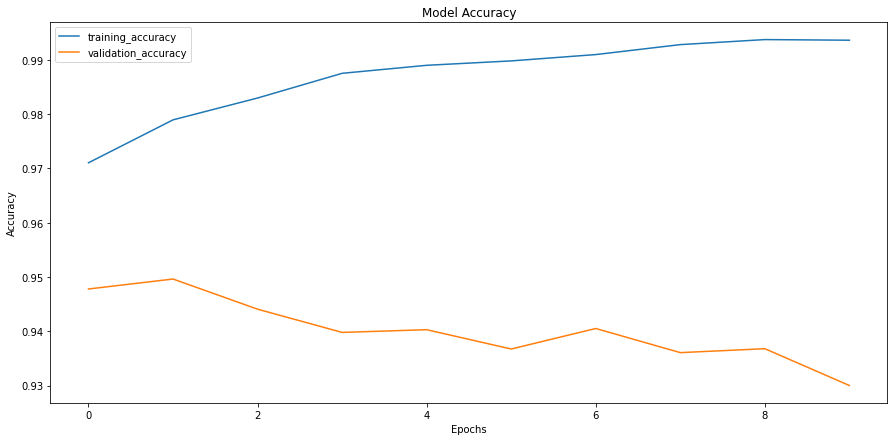

In [14]:
# Evaluating the model accuracy
plt.figure(figsize=(15,7))
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.show()

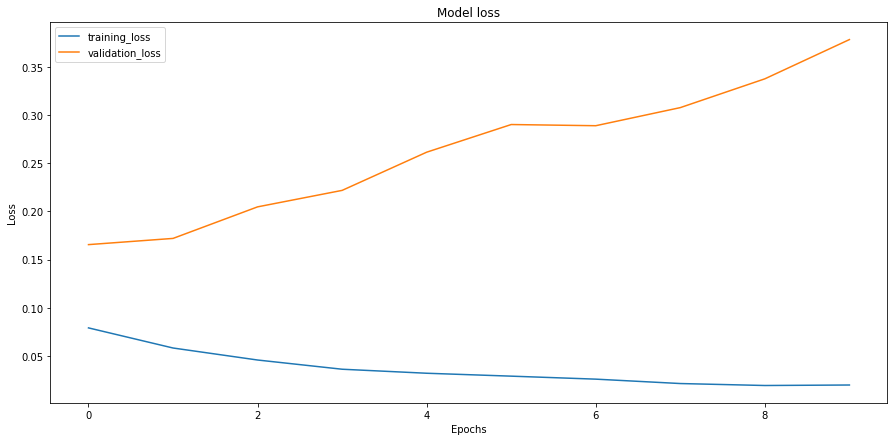

In [15]:
# Evaluating the Loss
plt.figure(figsize=(15,7))
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['training_loss', 'validation_loss'])
plt.show()